In [1]:
from math import *
from numpy import *
import matplotlib.pyplot as plt

In [2]:
#This is just to have everything at place.
#When you do it, you will import these functions from a library instead

import numpy as np
from numpy.matlib import repmat,randn

def createmcdata(yinp,ysiginp,nmc,distrib):

	#      function ymc = createmcdata(y,ysig,nmc,distrib)
	#
	# Creates a matrix ymc of nmc vectors with the mean values of y but with
	# added random noise of standard deviation ysig. 
	#
	#     y       data vector
	#     ysig    standard deviation vector (same length as y)
	#     nmc     number of Monte Carlo copies
	#     distrib 'norm' gives normal distribution
	#             'lognorm' give lognormal distribution (useful for example 
	#             if negative results are unphysical)
	#
	#
	#  You might want to initialize the random number generator in forehand.
	#

	yinp = np.asarray(yinp)
	ysiginp = np.asarray(ysiginp)
	if np.size(yinp) != np.size(ysiginp):
		raise Exception('y and ysig must be vectors of the same length.')

	n=np.size(yinp)
	y=yinp.reshape((1,n))
	ysig=ysiginp.reshape((1,n))
	if distrib.lower() in ('norm' ,'normal'):
		
		return np.array(repmat(y,nmc,1)) + np.array(repmat(ysig,nmc,1))*np.array(randn(nmc,n))
	elif  distrib.lower() in ('lognorm','lognormal'):
			mu = np.log(y**2/np.sqrt(ysig**2+y**2))  # mu of lognormal dist
			sigma = np.sqrt(np.log(ysig**2/y**2+1))  # sigma of lognormal dist
			return np.exp(np.array(randn(nmc,n))*np.array(repmat(sigma,nmc,1)) + np.array(repmat(mu,nmc,1)))
	else:
		raise Exception('Distribution named "' + distrib + '" is not recognized.')



def mclinreg(xinp, yinp, level):
	#This is a weighted-fit version (similar to MATLAB linregmc) that only handles linear fits
    #Performs linear fitting ax+b=y with error analysis 
    #using a Monte Carlo approach.
    
    #Input arguments:
    #  x : a NX x N matrix: the NX data sets of x values (N data points)
    #  y : a NY x N matrix: the NY data sets of y values (N data points)
    #      NX and NY need not be the same. In particular one may use a
    #      single data set (without added noise) for one of them.
    #      The number of fits equals max(NX,NY) and if there are less data
    #      sets for one of x or y, they are just cyclically reused.
    #  level : the confidence level for the returned confidence interval
    #          (must be between 0.5 and 1.0)
    #Return values:
    #  Returns four arrays, each of length n+1, containing the
    #  statistical analysis of the distribution of the fitted
    #  parameters:
    #  pmean : average value of each parameter (can be used as the result)
    #  psig  : standard deviation of each parameter
    #  plow  : low confidence bound for each parameter
    #  phigh : high confidence bound for each parameter
    #  pchi  : probability of chi>chi0
	

    if np.ndim(xinp) == 1:
        x=xinp.reshape((1,np.size(xinp)))
    else:
        x= xinp
    if np.ndim(yinp) == 1:
        y=yinp.reshape((1,np.size(yinp)))
    else:
        y=yinp
    if np.size(x,1) != np.size(y,1):
        raise Exception('Number of columns in x and y must be equal')
    if level>1 or level<0.5:
        raise Exception('Illegal confidence level')
    N=np.size(x,1)
    n=1 #always linear fit

	#Perform single fit to get the base chi2 value
    xs=np.median(x, axis=0)
    ys=np.median(y, axis=0)   #Reproduces original data points independent of distribution
    sig=np.std(x, axis=0)+np.std(y, axis=0)  #This only makes sense if either x or y is a single set

    Xt=np.stack((xs, np.ones(N)), axis=1)
    X=np.stack((xs/sig, np.ones(N)/sig), axis=1)
    Y=ys/sig
    pp=np.linalg.lstsq(X,Y, rcond=None)[0]    
    chi2 = sum((Y - np.matmul(X,pp))**2)
    subtract=ys - np.matmul(Xt,pp)


    xn=np.size(x,0)
    yn=np.size(y,0)
    nmc = max(xn,yn)
    pmc = np.zeros((nmc,n+1)) 
    chi2mc = np.zeros(nmc)
    for i in range(nmc):
        X=np.stack((x[i%xn,:]/sig,np.ones(N)/sig),axis=1)
        Y=(y[i%yn,:]-subtract)/sig
        p=np.linalg.lstsq(X,Y, rcond=None)[0] 
        pmc[i,:]=p
        chi2mc[i] = sum((Y - np.matmul(X,p))**2)
    #Statistisk analys av parametrarna i pmc: 
    # medelvärde, standardavvikelse och konfidensintervall
    #(t.ex. första och sista ventilen om nivån är 95%)
    pmean = np.mean(pmc,0)    #This is not used, as the single fit (pp) is returned for compatibility with the MATLAB script
    psig = np.std(pmc,0)
    plow = np.zeros(n+1)
    phigh = np.zeros(n+1)
    for j in range(n+1):
        tmp=np.sort(pmc[:,j])
        plow[j]=tmp[round(max(1,0.5*(1-level)*nmc))-1]
        phigh[j]=tmp[round(min(nmc,1-0.5*(1-level)*nmc))-1]
    
    #Compute pchi2
    pchi2=sum(chi2mc>chi2)/nmc

    return (pp,psig,plow,phigh,pchi2,pmc)



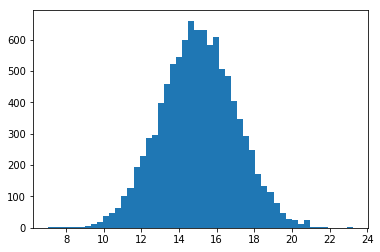

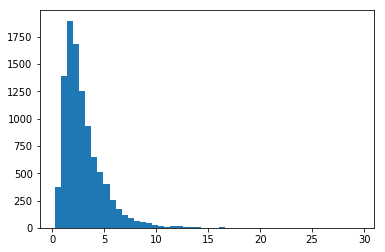

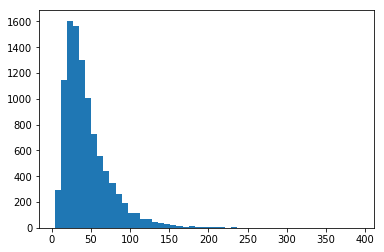

In [3]:
x = createmcdata(15,2,10000,'norm')
y = createmcdata(3,2,10000,'lognorm')

plt.hist(x,50)
plt.show()
plt.hist(y,50)
plt.show()

# Determine standard deviation of product
f = x*y
sig_f = std(f)

# Plot histogram of product
plt.hist(f,50)
plt.show()

[[1.         0.99910355]
 [0.99910355 1.        ]]


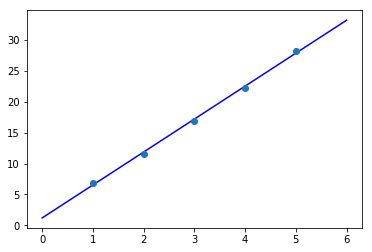

[5.33308 1.20218] [5.33308 1.20218]


In [4]:
#########################
# Linear regression part
#########################

# Create data for linear regression
x = array([1, 2, 3, 4, 5])
y = array([6.9331, 11.588, 16.953, 22.281, 28.252])
ysig = array([0.3, 0.2, 0.1, 0.1, 0.5])

# Plot it
plt.errorbar(x,y,yerr=ysig,fmt='o')

# Calculate correlation matrix
print(corrcoef(x, y))

# Linear regression (not weighted)
p = polyfit(x,y,1)
limx = array([0, 6])
plt.plot(limx,polyval(p,limx),'b-')
plt.show()

#Alternative to polyfit
X = hstack((x.reshape((len(x),1)),ones((len(x),1))))
pp = np.linalg.lstsq(X,y, rcond=None)[0]

print(p,pp)   # (gives same fit)




In [5]:
# Weighted fit with Monte Carlo estimated errors
y_mc=createmcdata(y,ysig,10000,'norm')
(pp,psig,plow,phigh,pchi2,pmc) = mclinreg(x,y_mc,0.95)


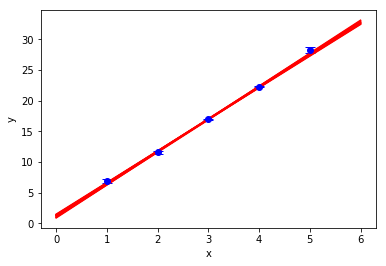

In [6]:
# Visualize result: Show 10 of the 10000 fits

plt.errorbar(x,y,fmt='bo',yerr=ysig,capsize=5)
for i in range(10):
    plt.plot(limx,polyval(pmc[i,:],limx),'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



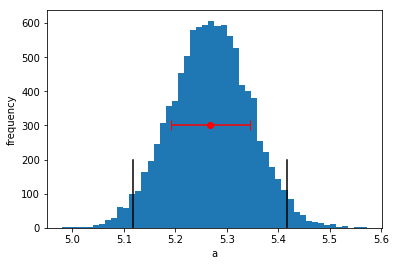

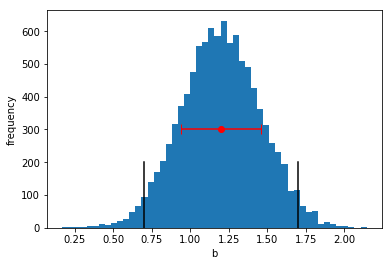

In [7]:
#Visualize results: Show distribution of a and b values, 
# and their standard deviation (red error bar) and
# confidence interval (black lines)

plt.figure(1)
plt.hist(pmc[:,0], bins=50)
plt.errorbar(pp[0],300,xerr=psig[0],fmt='ro',capsize=5)
plt.plot(array([plow[0],plow[0]]),array([0,200]),'k-')
plt.plot(array([phigh[0],phigh[0]]),array([0,200]),'k-')
plt.xlabel('a')
plt.ylabel('frequency')
plt.show()

plt.figure(2)
plt.hist(pmc[:,1], bins=50)
plt.errorbar(pp[1],300,xerr=psig[1],fmt='ro',capsize=5)
plt.plot(array([plow[1],plow[1]]),array([0,200]),'k-')
plt.plot(array([phigh[1],phigh[1]]),array([0,200]),'k-')

plt.xlabel('b')
plt.ylabel('frequency')


plt.show()



Confidence limits on slope: 5.118134552059227 5.418193468280763
Confidence limits on intercept: 0.6978711376835329 1.6993146658849796
Uncertainty (stdev) of extrapolated y value: 0.29437781437513455


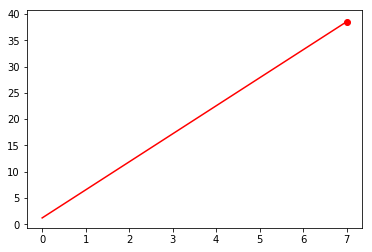

In [8]:
print("Confidence limits on slope:", plow[0], phigh[0])
print("Confidence limits on intercept:", plow[1], phigh[1])


# Extrapolation
xextr = 7     #array([[2.5, 7]])
yextr = p[0]*xextr + p[1]

# Error of extrapolation
# std dev
yextr_sig = std(pmc[:,0]*xextr + pmc[:,1])
print("Uncertainty (stdev) of extrapolated y value:", yextr_sig)
# or error on chosen conf level 
#not implemented yet

# Plot extrapolated points
plt.errorbar(xextr,yextr,yerr=yextr_sig,fmt='ro')
xlong = linspace(0,7,300);
plt.plot(xlong,polyval(p,xlong),'r-')